In [2]:
import os
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
font_size = 13
figsize = (6, 3)
rcParams = {
    "font.size": font_size,
    "font.family": "serif",
    "font.serif": "Times New Roman",
}
sns.set_theme(context="notebook", style="whitegrid", palette="colorblind", rc=rcParams)
sf_map = {"ce_loss": "CELoss", "cum_acc": "CumAcc", "fit": "FIT", "pd": "PD"}
sf_type = {
    "CELoss": "CELoss",
    "CumulativeAccuracy": "CumAcc",
    "FirstIteration": "FIT",
    "PredictionDepth": "PD",
}

In [4]:
def read_correlation_metrics(dataset: str) -> pd.DataFrame:
    # based on the results of 4_b_2_robustness_ensemble.ipynb
    df = pd.read_csv(f"results/tables/4_b_2_robustness_ensemble_{dataset}.csv")
    df["sf"] = df["sf"].map(sf_map)
    df = df.melt(id_vars="sf", var_name="Ensemble Size", value_name="Correlation")
    df["Ensemble Size"] = df["Ensemble Size"].astype(int)
    return df


def read_pacing_metrics(path: str, subdir: str = "summary") -> pd.DataFrame:
    metrics_df = pd.read_csv(f"{path}/{subdir}/metrics.csv")
    config_df = pd.read_csv(f"{path}/{subdir}/config.csv")
    df = pd.merge(metrics_df, config_df, on="run_name")
    return df


def filter_relevant_runs(df: pd.DataFrame) -> pd.DataFrame:
    def _endswith_sx(x: pd.Series) -> pd.Series:
        return x.str.endswith("-S1") | x.str.endswith("-S2") | x.str.endswith("-S3")

    df = df.dropna(subset=["curriculum.scoring"])
    df = df[
        df["curriculum.scoring"].str.contains("\+")
        | _endswith_sx(df["curriculum.scoring"])
    ]
    df = df[df["curriculum.scoring.type"].isin(sf_type.keys())]
    df["sf"] = df["curriculum.scoring.type"].map(sf_type)
    return df


def assign_ensemble_size(df: pd.DataFrame) -> pd.DataFrame:
    def size(x: str) -> int:
        return len(x.split("+"))

    df["Ensemble Size"] = df["curriculum.scoring"].apply(size)
    return df


def average_ensemble_performance(df: pd.DataFrame) -> pd.DataFrame:
    df = (
        df[["sf", "Ensemble Size", "test_accuracy"]]
        .groupby(["sf", "Ensemble Size"])
        .mean()
        .reset_index()
        .rename(columns={"test_accuracy": "Accuracy"})
    )
    return df


def create_correlation_performance(dataset: str) -> pd.DataFrame:
    corr = read_correlation_metrics(dataset)
    pacing = read_pacing_metrics(f"results/{dataset}", subdir="agg_seed")
    pacing = filter_relevant_runs(pacing)
    pacing = assign_ensemble_size(pacing)
    pacing = average_ensemble_performance(pacing)
    df = pd.merge(corr, pacing, on=["sf", "Ensemble Size"])
    df.rename(columns={"sf": "Scoring Function"}, inplace=True)
    return df

In [5]:
cifar_df = create_correlation_performance("cifar")
dcase_df = create_correlation_performance("dcase")
os.makedirs("results/tables", exist_ok=True)
cifar_df.to_csv("results/tables/4_c_2_robust_curriculum_cifar.csv", index=False)
dcase_df.to_csv("results/tables/4_c_2_robust_curriculum_dcase.csv", index=False)

In [6]:
def macro_micro_pcc(df: pd.DataFrame) -> Tuple[float, float]:
    macro_pcc = (
        df.groupby("Scoring Function")[["Accuracy", "Correlation"]]
        .corr("pearson")
        .iloc[0::2, -1]
        .mean()
    )
    micro_pcc = df[["Accuracy", "Correlation"]].corr("pearson").iloc[0, 1]
    return macro_pcc, micro_pcc

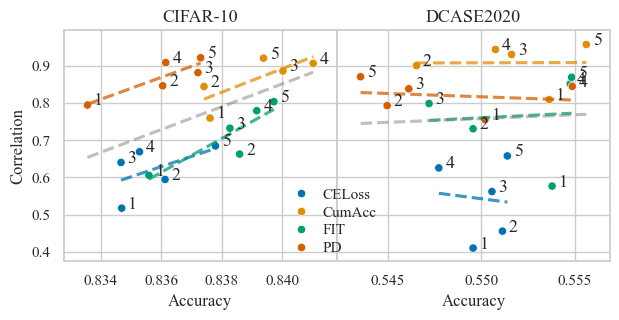

In [7]:
fig = plt.figure(figsize=figsize)


def _regplot(df: pd.DataFrame, a: float, ax: plt.Axes, color: str = None) -> None:
    sns.regplot(
        data=df,
        x="Accuracy",
        y="Correlation",
        scatter=False,
        color=color,
        ax=ax,
        ci=None,
        line_kws={
            "linestyle": "dashed",
            "alpha": a,
        },
    )


for i, df in enumerate([cifar_df, dcase_df]):
    plt.subplot(1, 2, i + 1)
    title = "CIFAR-10" if i == 0 else "DCASE2020"
    plt.title(title, fontsize=font_size)
    ax = sns.scatterplot(data=df, x="Accuracy", y="Correlation", hue="Scoring Function")
    for sf in df["Scoring Function"].unique():
        _regplot(df[df["Scoring Function"] == sf], 0.75, ax)

    _regplot(df, 0.5, ax, color="gray")

    for _, row in df.iterrows():
        ax.annotate(
            row["Ensemble Size"],
            (row["Accuracy"], row["Correlation"]),
            textcoords="offset points",
            xytext=(8, 4),
            ha="center",
            va="center_baseline",
            fontsize=font_size,
        )

    ax.set_ylim(bottom=0.375, top=0.995)
    ax.set_xlim(
        left=ax.get_xlim()[0] - 0.05 * (ax.get_xlim()[1] - ax.get_xlim()[0]),
        right=ax.get_xlim()[1] + 0.05 * (ax.get_xlim()[1] - ax.get_xlim()[0]),
    )
    ax.get_legend().remove()

    if i == 1:
        plt.setp(ax.get_yticklabels(), visible=False)
        ax.set_ylabel("")
        plt.subplots_adjust(wspace=0)

handles, labels = ax.get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    title=None,
    frameon=False,
    loc="center",
    bbox_to_anchor=(0.54, 0.295),
    handlelength=1.2,
    fontsize=font_size - 2,
    labelspacing=0.25,
)

os.makedirs("results/figures", exist_ok=True)
plt.tight_layout(pad=0)
plt.savefig("results/figures/4_c_2_robust_curriculum.pdf", dpi=300)

In [8]:
df = pd.DataFrame(
    {
        "PCC": ["Macro", "Micro"],
        "CIFAR-10": [*macro_micro_pcc(cifar_df)],
        "DCASE2020": [*macro_micro_pcc(dcase_df)],
    }
)
df.to_csv("results/tables/4_c_2_robust_curriculum.csv", index=False)
df.round(3)

,PCC,CIFAR-10,DCASE2020
0,Macro,0.760,-0.047
1,Micro,0.498,0.045
